Using daily averages

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import pickle
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
buoy = sio.loadmat('/ocean/rich/home/metro/ecbuoy/matlab/ECBUOY.mat')

In [3]:
buoy = buoy['ecbuoy']

In [4]:
buoy_dtype = buoy.dtype
buoydata = {n: buoy[n][0, 0] for n in buoy_dtype.names}

In [5]:
buoydata.keys()

dict_keys(['comment', 'lat', 'lon', 'tz', 'mtime', 'temp', 'specc', 'turb', 'salR', 'vel', 'airtemp', 'cwind', 'wspd', 'wdir', 'wu', 'wv', 'pH', 'O2', 'O2sat', 'dailyturb'])

In [6]:
temps = buoydata['temp'][:,0]
sals = buoydata['salR'][:,0]
mtimes = buoydata['mtime'][:,0]

In [7]:
mtimes.shape

(76535,)

In [8]:
base = datetime.datetime(2000, 1, 1)
py_buoy_times = np.array([base for i in range(76535)])
print(py_buoy_times.shape)
for n in range(76535):
    py_buoy_times[n] = ((datetime.datetime.fromordinal(int(mtimes[n])))
                       + datetime.timedelta(days=mtimes[n]%1)
                       - datetime.timedelta(days = 366))

(76535,)


In [9]:
nowcast = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV17-02')

In [10]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [11]:
buoydata['lon'][0][0]

-123.03856589999999

In [12]:
geo_tools.find_closest_model_point(buoydata['lon'][0][0], buoydata['lat'][0][0], 
                                   X, Y, land_mask = bathy.mask)

(415, 337)

In [13]:
temps = temps[py_buoy_times > datetime.datetime(2014, 9, 12)]
sals = sals[py_buoy_times > datetime.datetime(2014, 9, 12)]
py_buoy_times = py_buoy_times[py_buoy_times > datetime.datetime(2014, 9, 12)]

In [15]:
print(temps.shape)

(26462,)


In [21]:
import pytz
local = pytz.timezone ("America/Los_Angeles")
utc_datetimes = np.array([local.localize(py_buoy_times[n], 
                                         is_dst=True).astimezone(pytz.utc)
                          for n in range(26462)])

In [22]:
temps = np.ma.masked_invalid(temps)
utc_datetimes = np.ma.masked_array(utc_datetimes, mask = temps.mask)

In [23]:
np.ma.count(utc_datetimes)

23112

In [24]:
utc_datetimes = utc_datetimes.compressed()

In [25]:
days = np.array([])
for n in range(23112):
    day = datetime.date(utc_datetimes[n].year, utc_datetimes[n].month, utc_datetimes[n].day)
    days = np.append(days, day)

In [26]:
d = { 'temperature': temps.compressed(), 
     'salinity': np.ma.masked_invalid(sals).compressed(), 'day': days}
buoy_table = pd.DataFrame(d)

In [27]:
averaged_daily_salinity = np.array([])
averaged_daily_temperature = np.array([])
for day in buoy_table.day.unique():
    sal = buoy_table.loc[buoy_table['day'] == day].salinity.mean()
    temp = buoy_table.loc[buoy_table['day'] == day].temperature.mean()
    averaged_daily_salinity = np.append(averaged_daily_salinity, sal)
    averaged_daily_temperature = np.append(averaged_daily_temperature, temp)
print(averaged_daily_salinity.shape)
print(averaged_daily_temperature.shape)

(1018,)
(1018,)


In [28]:
import os

In [29]:
HINDCAST_PATH = '/results/SalishSea/nowcast-green/'

In [30]:
model_surface_sal = np.array([])
model_surface_temp = np.array([])
model_1_5_sal = np.array([])
model_1_5_temp = np.array([])
for day in buoy_table.day.unique():
    sub_dir = day.strftime('%d%b%y').lower()
    datestr = day.strftime('%Y%m%d')
    fname = 'SalishSea_1d_{}_{}_grid_T.nc'.format(datestr, datestr)
    nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
    sal_val0 = nuts.variables['vosaline'][0, 0, 415, 337]
    sal_val1 = nuts.variables['vosaline'][0, 1, 415, 337]
    model_surface_sal = np.append(model_surface_sal, sal_val0)
    model_1_5_sal = np.append(model_1_5_sal, sal_val1)
    t_val0 = nuts.variables['votemper'][0, 0, 415, 337]
    t_val1 = nuts.variables['votemper'][0, 1, 415, 337]
    model_surface_temp = np.append(model_surface_temp, t_val0)
    model_1_5_temp = np.append(model_1_5_temp, t_val1)

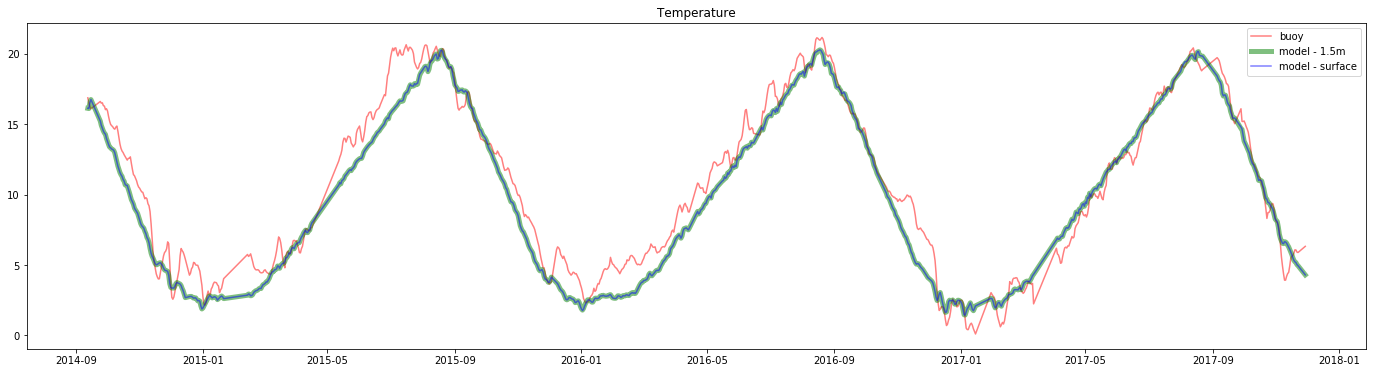

In [31]:
fig, ax = plt.subplots(figsize = (24,6))
ax.plot(buoy_table.day.unique(), averaged_daily_temperature, 'r-', alpha = 0.5, label = 'buoy')
ax.plot(buoy_table.day.unique(), model_1_5_temp, 'g-', alpha = 0.5, linewidth = 5, label = 'model - 1.5m')
ax.plot(buoy_table.day.unique(), model_surface_temp, 'b-', alpha = 0.5, label = 'model - surface')
ax.legend()
ax.set_title('Temperature');

In [32]:
from matplotlib.colors import LogNorm

bias =  -0.832611264165
RMSE = 1.47607008425
Willmott = 0.983654461941


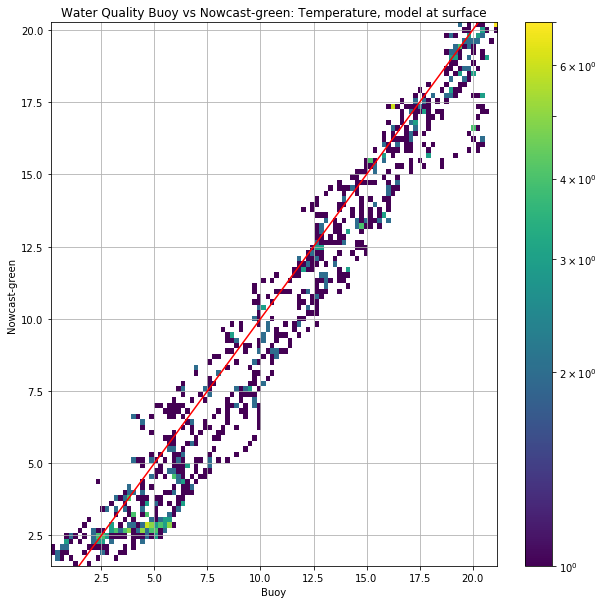

In [33]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(averaged_daily_temperature, model_surface_temp,  
                                bins = 100, norm=LogNorm())
fig.colorbar(im, ax=ax)
ax.plot(np.arange(0,22), 'r-')
ax.grid('on')
ax.set_title('Water Quality Buoy vs Nowcast-green: Temperature, model at surface')
ax.set_xlabel('Buoy')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(averaged_daily_temperature) + np.mean(model_surface_temp)))
print('RMSE = ' + str(np.sqrt(np.sum((model_surface_temp - averaged_daily_temperature)**2) /
                              len(averaged_daily_temperature))))
xbar = np.mean(averaged_daily_temperature)
print('Willmott = ' + str(1-(np.sum((model_surface_temp - averaged_daily_temperature)**2)  / 
                             np.sum((np.abs(model_surface_temp - xbar) 
                                     + np.abs(averaged_daily_temperature - xbar))**2))))

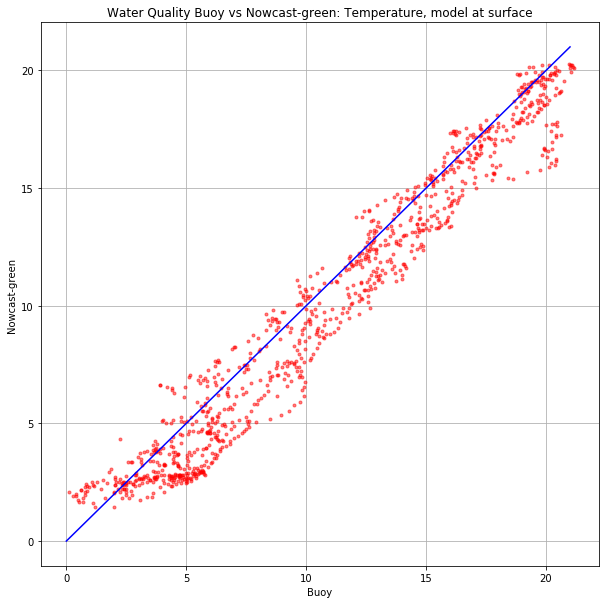

In [34]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(averaged_daily_temperature, model_surface_temp, 'r.', alpha = 0.5)
ax.plot(np.arange(0,22), 'b-')
ax.grid('on')
ax.set_title('Water Quality Buoy vs Nowcast-green: Temperature, model at surface')
ax.set_xlabel('Buoy')
ax.set_ylabel('Nowcast-green');

bias =  -0.836122671334
RMSE = 1.47791652105
Willmott = 0.983595919817


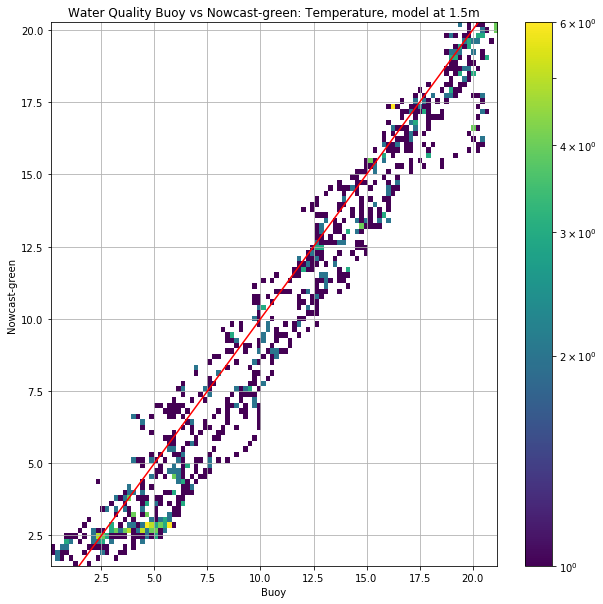

In [35]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(averaged_daily_temperature, model_1_5_temp,  
                                bins = 100, norm=LogNorm())
fig.colorbar(im, ax=ax)
ax.plot(np.arange(0,22), 'r-')
ax.grid('on')
ax.set_title('Water Quality Buoy vs Nowcast-green: Temperature, model at 1.5m')
ax.set_xlabel('Buoy')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(averaged_daily_temperature) + np.mean(model_1_5_temp)))
print('RMSE = ' + str(np.sqrt(np.sum((model_1_5_temp - averaged_daily_temperature)**2) /
                              len(averaged_daily_temperature))))
xbar = np.mean(averaged_daily_temperature)
print('Willmott = ' + str(1-(np.sum((model_1_5_temp - averaged_daily_temperature)**2)  / 
                             np.sum((np.abs(model_1_5_temp - xbar) 
                                     + np.abs(averaged_daily_temperature - xbar))**2))))

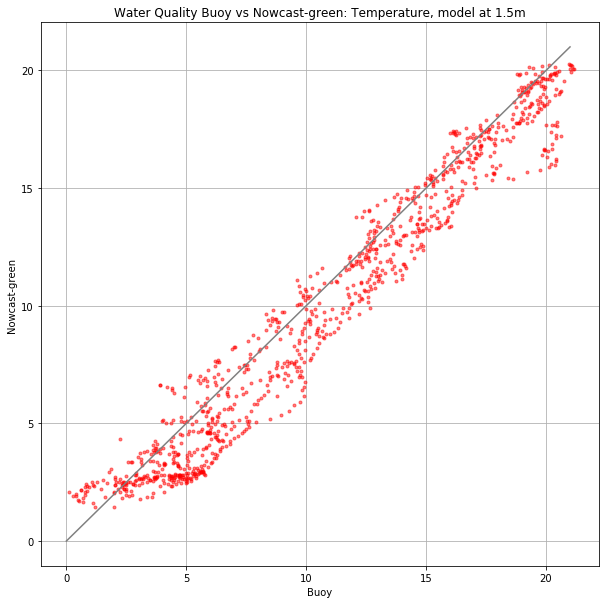

In [36]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(averaged_daily_temperature, model_1_5_temp, 'r.', alpha = 0.5)
ax.plot(np.arange(0,22), '-', color = 'grey')
ax.grid('on')
ax.set_title('Water Quality Buoy vs Nowcast-green: Temperature, model at 1.5m')
ax.set_xlabel('Buoy')
ax.set_ylabel('Nowcast-green');

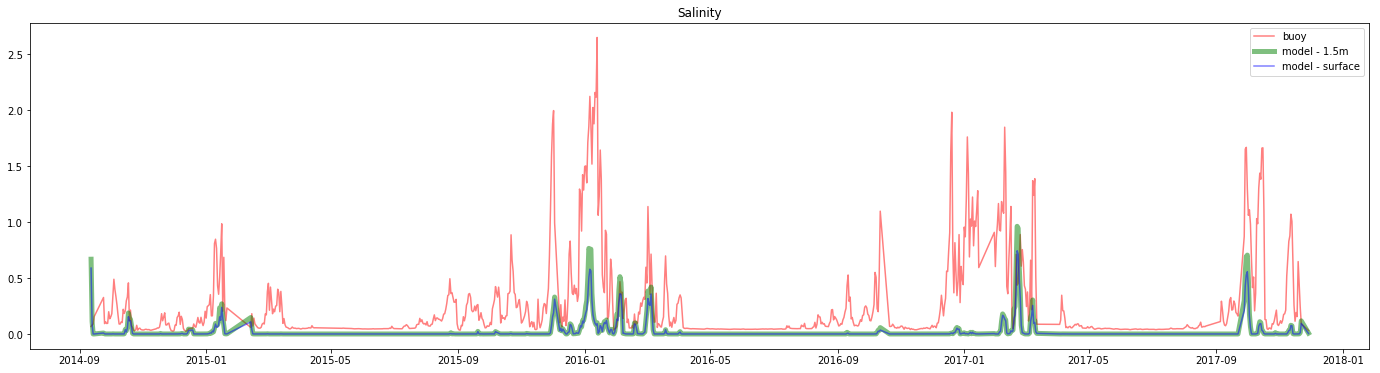

In [37]:
fig, ax = plt.subplots(figsize = (24,6))
ax.plot(buoy_table.day.unique(), averaged_daily_salinity, 'r-', alpha = 0.5, label = 'buoy')
ax.plot(buoy_table.day.unique(), model_1_5_sal, 'g-', alpha = 0.5, linewidth = 5, label = 'model - 1.5m')
ax.plot(buoy_table.day.unique(), model_surface_sal, 'b-', alpha = 0.5, label = 'model - surface')
ax.legend()
ax.set_title('Salinity');

bias =  -0.22527762646
RMSE = 0.407611386028
Willmott = 0.439160272325


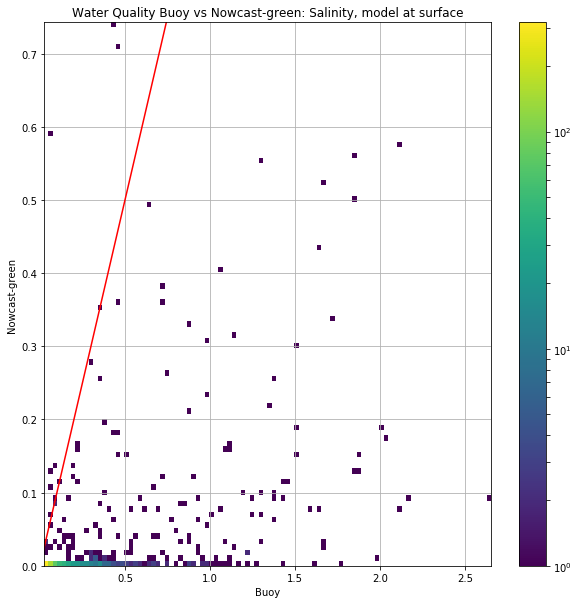

In [38]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(averaged_daily_salinity, model_surface_sal,  
                                bins = 100, norm=LogNorm())
fig.colorbar(im, ax=ax)
ax.plot(np.arange(0,3), 'r-')
ax.grid('on')
ax.set_title('Water Quality Buoy vs Nowcast-green: Salinity, model at surface')
ax.set_xlabel('Buoy')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(averaged_daily_salinity) + np.mean(model_surface_sal)))
print('RMSE = ' + str(np.sqrt(np.sum((model_surface_sal - averaged_daily_salinity)**2) /
                              len(averaged_daily_salinity))))
xbar = np.mean(averaged_daily_salinity)
print('Willmott = ' + str(1-(np.sum((model_surface_sal - averaged_daily_salinity)**2)  / 
                             np.sum((np.abs(model_surface_sal - xbar) 
                                     + np.abs(averaged_daily_salinity - xbar))**2))))

bias =  -0.220574487694
RMSE = 0.401423952613
Willmott = 0.465306250042


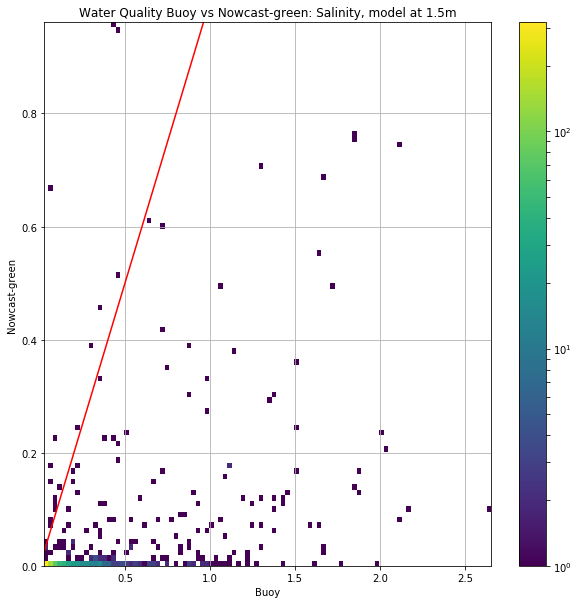

In [39]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(averaged_daily_salinity, model_1_5_sal,  
                                bins = 100, norm=LogNorm())
fig.colorbar(im, ax=ax)
ax.plot(np.arange(0,3), 'r-')
ax.grid('on')
ax.set_title('Water Quality Buoy vs Nowcast-green: Salinity, model at 1.5m')
ax.set_xlabel('Buoy')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(averaged_daily_salinity) + np.mean(model_1_5_sal)))
print('RMSE = ' + str(np.sqrt(np.sum((model_1_5_sal - averaged_daily_salinity)**2) /
                              len(averaged_daily_salinity))))
xbar = np.mean(averaged_daily_salinity)
print('Willmott = ' + str(1-(np.sum((model_1_5_sal - averaged_daily_salinity)**2)  / 
                             np.sum((np.abs(model_1_5_sal - xbar) 
                                     + np.abs(averaged_daily_salinity - xbar))**2))))